In [30]:
import json
import re
import csv
import numpy as np
import pandas as pd
from geotext import GeoText
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import emoji
import collections
from string import punctuation 
import matplotlib.pyplot as plt
import matplotlib

In [2]:
with open('coor_to_sa2.json') as json_file:
    data = json.load(json_file)

australia = pd.read_csv('australian_postcodes.csv')

In [3]:
city = list(w for w in australia['locality'])
state = list(w for w in australia['state'])
unique_city = list(set(city))
unique_state = list(set(state))

AU_CITY = [c.lower() for c in unique_city]
AU_STATE = [s.lower() for s in unique_state]
AU = AU_CITY +AU_STATE

### Hashtag Aggregation 

In [4]:
lemmatizer = WordNetLemmatizer() 
hashtag= []
def get_hashtags(sentence):
    sent = sentence.lower()
    h = re.findall(r"#(\w+)", sent)
    lemma_hashtag = [lemmatizer.lemmatize(w) for w in h]
    hashtag.extend(w for w in lemma_hashtag if len(w)>2 if w not in AU if not any(w1.isdigit() for w1 in w) if w != 'australia' if w!= 'Australia')
    return hashtag

In [5]:
hashtag_dic = {}
for i in data:
    hashtag=[]
    for s in data[i]:
        get_hashtags(s)
    hashtag_dic[i] = hashtag

In [6]:
hashtag_dic

{'117031331': ['travel',
  'familytrip',
  'vacationmode',
  'dearjerry',
  'salsa',
  'glamour',
  'sep',
  'coffee',
  'screenwriter',
  'razinoz',
  'urinal',
  'throwback',
  'strategynonsense',
  'startup',
  'consulting',
  'teamocielo',
  'dinner',
  'despana',
  'españa',
  'babynixon',
  'princeakkanatan',
  'gethooked',
  'forlease',
  'weather',
  'tea',
  'flourtorillas',
  'mexicanfood',
  'salsa',
  'monday',
  'sydneyfoodie',
  'vegetarian',
  'vegan',
  'here',
  'coffeemornings',
  'nedkellyawards',
  'pint',
  'repost',
  'motorcycle',
  'wallpaperporn',
  'theworldaccordingtobenjamin',
  'makai',
  'wanderlust'],
 '801111140': ['winterishere',
  'snow',
  'windchillfactor',
  'home',
  'snow',
  'mountain',
  'corinforest',
  'scenery',
  'naturephotography',
  'futureofcycling',
  'commissairelife',
  'visitcanberra',
  'igerscanberra',
  'canberratimes',
  'fog',
  'australiancapitalterritory',
  'aussie_shotz',
  'aussiephotos',
  'canberratimes',
  'hotornaremafe

In [7]:
bow_dic = {}
for i in hashtag_dic:
    for w in i:
        if w in bow_dic.keys():
            bow_dic[w] += 1
        else:
            bow_dic[w] =1

bow_by_loc = {}
for i in hashtag_dic:
    bow = {}
    for w in hashtag_dic[i]:
        if w in bow.keys():
            bow[w] += 1
        else:
            bow[w] =1
    bow_by_loc[i] = bow

In [25]:
sorted_dic = {}
for i in bow_by_loc:
    hashtag = {}
    sorted_fre = sorted(bow_by_loc[i].items(), key = lambda item:item[1], reverse=True) 
    for k,v in sorted_fre:
        if v>=5:
            hashtag[k] = v
    sorted_dic[i] = hashtag

In [27]:
with open('hashtag_final.json', 'w') as f:
    data = json.dump(sorted_dic, f)

In [45]:
def draw_topics(sa2, topic):
    labels = list(topic[sa2].keys())
    sizes =  list(topic[sa2].values())
    colors = ['deeppink','pink','rosybrown', 'gold', 'lightskyblue','salmon','orange','plum','hotpink','teal','orchid','yellowgreen','crimson','forestgreen']
    explode = (0.3, 0, 0, 0,0,0)  # explode 1st slice
    plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
    fontP = matplotlib.font_manager.FontProperties()
    fontP.set_size('small')
    plt.legend(patches, labels, prop=fontP,loc='right') 
    plt.tight_layout()
    plt.axis('equal')
    
    plt.show()

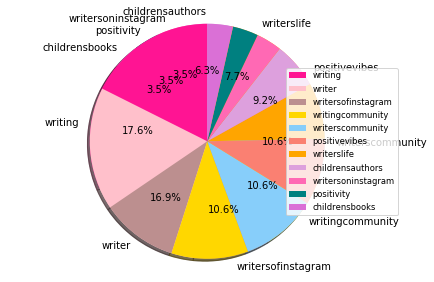

In [46]:
draw_topics('107031141', sorted_dic)

In [136]:
def drawBar_topics(sa2, topic):
    plt.style.use('ggplot')
    x= list(topic[sa2].keys())[:10][::-1]
    sizes =  list(topic[sa2].values())[:10][::-1]
    
    x_pos = [i for i, _ in enumerate(x)]
    plt.barh(range(len(x_pos)),sizes, color='green')
    plt.ylabel("Hashtags")
    plt.xlabel("Frequency")
    #plt.title("Energy output from various fuel sources")
    plt.yticks(range(len(x_pos)), x)

    plt.show()

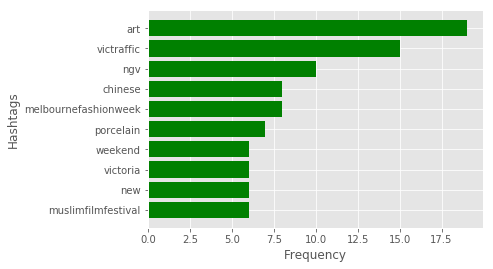

In [138]:
drawBar_topics('206041126', sorted_dic)

In [112]:
import couchdb
import requests
# Database Connection Configuration
IP = '45.113.234.131'
BASE_URL = 'http://45.113.234.131:5984'
USERNAME = 'admin'
PASSWORD = 'ck199451'
db = requests.Session()
db.auth = (USERNAME, PASSWORD)

In [113]:
couchserver = couchdb.Server(BASE_URL)
couchserver = couchdb.Server("http://%s:%s@%s:5984/" % (USERNAME, PASSWORD, IP))

In [ ]:
db = couchserver.create('hashtag')
for i in sorted_dic:
    db.save({'_id':i,'hashtags':sorted_dic[i]})

### Hashtag model

In [298]:
gensim_lda_topic = {}
lda_score = {}
for i in hashtag_dic:
    if len(hashtag_dic[i]) ==0:
        continue
    id2word = corpora.Dictionary([hashtag_dic[i]])
    corpus = [id2word.doc2bow(w) for w in [hashtag_dic[i]]]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics =5, id2word=id2word,update_every=1, alpha='auto',passes=15)
    topics = ldamodel.print_topics(num_words=5)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=[hashtag_dic[i]], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    gensim_lda_topic[i] = topics
    lda_score[i] = [ldamodel.log_perplexity(corpus),coherence_lda]

In [299]:
gensim_lda_topic

{'117031331': [(0,
   '0.044*"salsa" + 0.024*"dearjerry" + 0.024*"pint" + 0.024*"consulting" + 0.024*"despana"'),
  (1,
   '0.024*"salsa" + 0.024*"strategynonsense" + 0.024*"españa" + 0.024*"vegan" + 0.024*"nedkellyawards"'),
  (2,
   '0.024*"salsa" + 0.024*"makai" + 0.024*"wallpaperporn" + 0.024*"gethooked" + 0.024*"princeakkanatan"'),
  (3,
   '0.024*"salsa" + 0.024*"monday" + 0.024*"travel" + 0.024*"sep" + 0.024*"dinner"'),
  (4,
   '0.024*"mexicanfood" + 0.024*"tea" + 0.024*"repost" + 0.024*"screenwriter" + 0.024*"sydneyfoodie"')],
 '801111140': [(0,
   '0.031*"canberratimes" + 0.031*"australiancapitalterritory" + 0.031*"snow" + 0.031*"futureofcycling" + 0.031*"commissairelife"'),
  (1,
   '0.031*"australiancapitalterritory" + 0.031*"canberratimes" + 0.031*"snow" + 0.031*"corinforest" + 0.031*"aussiephotos"'),
  (2,
   '0.053*"canberratimes" + 0.053*"australiancapitalterritory" + 0.053*"snow" + 0.029*"tidbinbillanaturereserve" + 0.029*"windchillfactor"'),
  (3,
   '0.031*"australia

In [300]:
topic_dic = {}    
for i in gensim_lda_topic:
    topic = []
    for t in gensim_lda_topic[i]:
        formula = t[1].split()
        for w in formula:
            if w == '+':
                continue
            topic.append(re.sub(r'[^\w]','',w)[4:])
    topic_dic[i] = topic

In [301]:
topic_dic

{'117031331': ['salsa',
  'dearjerry',
  'pint',
  'consulting',
  'despana',
  'salsa',
  'strategynonsense',
  'españa',
  'vegan',
  'nedkellyawards',
  'salsa',
  'makai',
  'wallpaperporn',
  'gethooked',
  'princeakkanatan',
  'salsa',
  'monday',
  'travel',
  'sep',
  'dinner',
  'mexicanfood',
  'tea',
  'repost',
  'screenwriter',
  'sydneyfoodie'],
 '801111140': ['canberratimes',
  'australiancapitalterritory',
  'snow',
  'futureofcycling',
  'commissairelife',
  'australiancapitalterritory',
  'canberratimes',
  'snow',
  'corinforest',
  'aussiephotos',
  'canberratimes',
  'australiancapitalterritory',
  'snow',
  'tidbinbillanaturereserve',
  'windchillfactor',
  'australiancapitalterritory',
  'canberratimes',
  'snow',
  'gibraltarrocks',
  'home',
  'snow',
  'australiancapitalterritory',
  'canberratimes',
  'walk',
  'dalsetta'],
 '206041121': ['victraffic',
  'blue',
  'cloud',
  'sun',
  'sky',
  'victraffic',
  'blue',
  'cloud',
  'cnnweather',
  'sky',
  'blue

In [302]:
## choose the top 5 frequency as final topics for each area
hashtag_sort_topic = {}
for i in topic_dic:
    topic_fre = {}
    for w in topic_dic[i]:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    hashtag_sort_topic[i] = sorted_topic_fre[:5]

In [303]:
final_lda_hashtag_topics = {}
for i in hashtag_sort_topic:
    topic = []
    for t in hashtag_sort_topic[i]:
        topic.append(t[0])
    final_lda_hashtag_topics[i] = topic

In [304]:
final_lda_hashtag_topics

{'117031331': ['salsa', 'dearjerry', 'pint', 'despana', 'strategynonsense'],
 '801111140': ['canberratimes',
  'australiancapitalterritory',
  'snow',
  'commissairelife',
  'corinforest'],
 '206041121': ['victraffic', 'blue', 'cloud', 'sun', 'sky'],
 '126011496': ['dilf'],
 '111031229': ['newcastlensw',
  'newsouthwales',
  'uonsportsawards',
  'nobbysbreakwall',
  'newcastlebeach'],
 '701011004': ['mindilbeach',
  'darwinaustralia',
  'chewie',
  'northernterritory',
  'darwinnt'],
 '114011281': ['dirtxseries',
  'myactionimages',
  'nowramotoplex',
  'dirtx',
  'noreception'],
 '206041126': ['art', 'victraffic', 'ngv', 'melbournefashionweek', 'chinese'],
 '503021038': ['keepmovingperth',
  'keepmovingmthawthorn',
  'bmw',
  'mojito',
  'blackberry'],
 '206061137': ['art', 'artwork', 'artoftheday', 'painting', 'abstractart'],
 '303051076': ['ybaf',
  'pilotskills',
  'cityviews',
  'digitaldealer',
  'samsmodel'],
 '504011047': ['likeforlike',
  'confucius',
  'habibi',
  'freshtodea

In [307]:
lda_tweet_coherence = []
lda_tweet_perplexity = []
for i in lda_score:
    lda_tweet_coherence.append(lda_score[i][1])
    lda_tweet_perplexity.append(lda_score[i][0])

lda_score_table = pd.DataFrame()
lda_score_table['sa2_code'] = lda_score.keys()
lda_score_table['lda_hashtag_coherence'] = lda_tweet_coherence
lda_score_table['lda_hashtag_perplexity'] = lda_tweet_perplexity
lda_score_table['hot_hashtag'] = final_lda_hashtag_topics.values()

In [317]:
lda_score_table.to_csv('hashtag_lda_table.csv', index = False)

In [320]:
lda_score_table.head(10)

,sa2_code,lda_hashtag_coherence,lda_hashtag_perplexity,hot_hashtag
0,117031331,1.000000,-4.821555,"[salsa, dearjerry, pint, despana, strategynons..."
1,801111140,1.000000,-4.502051,"[canberratimes, australiancapitalterritory, sn..."
2,206041121,1.000000,-4.782495,"[victraffic, blue, cloud, sun, sky]"
3,126011496,1.000000,-0.191712,[dilf]
4,111031229,0.180524,-5.186477,"[newcastlensw, newsouthwales, uonsportsawards,..."
5,701011004,1.000000,-4.595089,"[mindilbeach, darwinaustralia, chewie, norther..."
6,114011281,1.000000,-3.218856,"[dirtxseries, myactionimages, nowramotoplex, d..."
7,206041126,0.292343,-7.135972,"[art, victraffic, ngv, melbournefashionweek, c..."
8,503021038,1.000000,-4.562039,"[keepmovingperth, keepmovingmthawthorn, bmw, m..."
9,206061137,0.388330,-4.602278,"[art, artwork, artoftheday, painting, abstract..."


### Gensim LDA plot

Text(0, 0.5, 'Count of Areas')

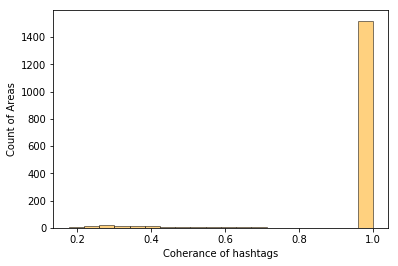

In [312]:
import matplotlib.pyplot as plt
import matplotlib

plt.hist(lda_tweet_coherence, bins = 20,facecolor="orange", edgecolor="black", alpha=0.5)
plt.xlabel('Coherance of hashtags')
plt.ylabel('Count of Areas')

In [200]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
3      0.072785 -0.0       1        1  99.973976
1     -0.018569 -0.0       2        1   0.008760
4     -0.018378 -0.0       3        1   0.007460
2     -0.018203 -0.0       4        1   0.006452
0     -0.017634 -0.0       5        1   0.003353, topic_info=    Category       Freq                           Term      Total  loglift  \
91   Default  23.000000                   newcastlensw  23.000000  30.0000   
95   Default  19.000000                  newsouthwales  19.000000  29.0000   
155  Default  13.000000                uonsportsawards  13.000000  28.0000   
97   Default   9.000000                nobbysbreakwall   9.000000  27.0000   
88   Default   8.000000                 newcastlebeach   8.000000  26.0000   
134  Default   8.000000                      teamforum   8.000000  25.0000   
154  Default   7.000000                            uon   7.000000  24.0000   
135  Default   7.000000                        teamuon   7.000000  23.0000   
98   Default   7.000000                     nobbyshead   7.000000  22.0000   
59   Default   5.000000                 healthychoices   5.000000  21.0000   
149  Default   5.000000         totalperformancecentre   5.000000  20.0000   
30   Default   5.000000  dionjamespitmaninnewcastlensw   5.000000  19.0000   
84   Default   3.000000                    mynewcastle   3.000000  18.0000   
11   Default   3.000000                          beach   3.000000  17.0000   
99   Default   3.000000                nobbysheadlight   3.000000  16.0000   
104  Default   2.000000                    onesongsing   2.000000  15.0000   
127  Default   1.000000                         straya   1.000000  14.0000   
90   Default   1.000000             newcastlelightrail   1.000000  13.0000   
73   Default   1.000000                      lightrail   1.000000  12.0000   
71   Default   1.000000                liftinyourlunch   1.000000  11.0000   
62   Default   1.000000                    hunterriver   1.000000  10.0000   
112  Default   1.000000                 pushyourlimits   1.000000   9.0000   
121  Default   1.000000                        seagull   1.000000   8.0000   
120  Default   1.000000                            sea   1.000000   7.0000   
45   Default   1.000000                    forumfamily   1.000000   6.0000   
63   Default   1.000000        ifyoudonttryyouwontknow   1.000000   5.0000   
38   Default   1.000000                 finneganshotel   1.000000   4.0000   
77   Default   1.000000                           look   1.000000   3.0000   
75   Default   1.000000                         likeme   1.000000   2.0000   
4    Default   1.000000                       attitude   1.000000   1.0000   
..       ...        ...                            ...        ...      ...   
42    Topic5   0.000063                        foghorn   1.084940   0.5488   
82    Topic5   0.000063             milkylanenewcastle   1.084906   0.5488   
24    Topic5   0.000063                           cafe   1.084882   0.5488   
19    Topic5   0.000063                      bluetrack   1.084870   0.5487   
95    Topic5   0.000066                  newsouthwales  19.156431  -2.2730   
91    Topic5   0.000066                   newcastlensw  23.676725  -2.4865   
155   Topic5   0.000065                uonsportsawards  13.735721  -1.9612   
88    Topic5   0.000064                 newcastlebeach   8.312980  -1.4668   
134   Topic5   0.000064                      teamforum   8.314056  -1.4695   
97    Topic5   0.000064                nobbysbreakwall   9.217910  -1.5745   
154   Topic5   0.000064                            uon   7.410069  -1.3572   
59    Topic5   0.000064                 healthychoices   5.602448  -1.0779   
98    Topic5   0.000064                     nobbyshead   7.411164  -1.3591   
135   Topic5   0.000064                        teamuon   7.410669  -1.3590   
149   Topic5   0.000064   

In [10]:
import os
path = "pDMM-master/output/" #文件夹目录
files= os.listdir(path)

In [11]:
for i in range(0,1929):
    f = open('dmmModel'+str(i)+'.topWords', 'r'
    

dmmModel747.topWords
dmmModel521.topWords
dmmModel820.topicAssignments
dmmModel520.topWords
dmmModel746.topWords
dmmModel389.topWords
dmmModel1402.topWords
dmmModel1810.topicAssignments
dmmModel1892.topWords
dmmModel1664.topWords
dmmModel388.topWords
dmmModel1665.topWords
dmmModel1403.topWords
dmmModel1893.topWords
dmmModel1330.topWords
dmmModel1156.topWords
dmmModel8.topicAssignments
dmmModel1157.topWords
dmmModel1917.topicAssignments
dmmModel1331.topWords
dmmModel213.topWords
dmmModel1598.topWords
dmmModel1908.topWords
dmmModel212.topWords
dmmModel919.topicAssignments
dmmModel927.topicAssignments
dmmModel1599.topWords
dmmModel1909.topWords
dmmModel1713.topicAssignments
dmmModel429.topWords
dmmModel1510.topicAssignments
dmmModel1128.topicAssignments
dmmModel428.topWords
dmmModel1315.topicAssignments
dmmModel65.topicAssignments
dmmModel1116.topicAssignments
dmmModel83.topicAssignments
dmmModel723.topicAssignments
dmmModel281.topWords
dmmModel520.topicAssignments
dmmModel118.topicAssign

dmmModel1826.topicAssignments
dmmModel1236.topWords
dmmModel1818.topicAssignments
dmmModel1237.topWords
dmmModel23.topWords
dmmModel1051.topWords
dmmModel816.topicAssignments
dmmModel315.topWords
dmmModel828.topicAssignments
dmmModel173.topWords
dmmModel172.topWords
dmmModel314.topWords
dmmModel1839.topicAssignments
dmmModel558.topWords
dmmModel1807.topicAssignments
dmmModel559.topWords
dmmModel196.topWords
dmmModel809.topicAssignments
dmmModel837.topicAssignments
dmmModel197.topWords
dmmModel852.topWords
dmmModel1349.topWords
dmmModel853.topWords
dmmModel930.topicAssignments
dmmModel1348.topWords
dmmModel1787.topWords
dmmModel1900.topicAssignments
dmmModel1786.topWords
dmmModel734.topicAssignments
dmmModel636.topWords
dmmModel94.topicAssignments
dmmModel450.topWords
dmmModel509.topicAssignments
dmmModel537.topicAssignments
dmmModel451.topWords
dmmModel332.topicAssignments
dmmModel637.topWords
dmmModel131.topicAssignments
dmmModel1704.topicAssignments
dmmModel1539.topicAssignments
dmmM